In [25]:
##########################################################
# ---- Read HH data and take averages based on day and night times ----
##########################################################

# 01_vpd_daytime.R
# This script reads half-hourly data, extracts daytime average vapour pressure deficit (VPD_F_DAY),
# and writes the result to a CSV file.

# ---- Package Installation and Loading ----
# Ensure required packages are installed and loaded
required_packages <- c("dplyr", "lubridate")
installed_packages <- rownames(installed.packages())
for (pkg in required_packages) {
    if (!pkg %in% installed_packages) {
        install.packages(pkg, dependencies = TRUE)
    }
    library(pkg, character.only = TRUE)
}

# ---- Data Reading ----
# Read the half-hourly measurement file (CSV)
data <- read.csv("../data/FLX_CH-Oe2_FLUXNET2015_FULLSET_2004-2023_1-3/FLX_CH-Oe2_FLUXNET2015_FULLSET_DD_2004-2023_1-3.csv")
# head(data)      # Preview the first few rows
# colnames(data)  # Display column names

# ---- Extract PPFD columns and save to CSV ----
# Select date and PPFD-related columns
ppfd_data <- data %>%
    select(TIMESTAMP, SW_IN_F_MDS)

# ---- Convert SW_IN_F_MDS to PPFD using bigleaf package ----
library(bigleaf)
ppfd <- Rg.to.PPFD(ppfd_data$SW_IN_F_MDS, frac_PAR = 0.5)  # Example conversion
ppfd_data$ppfd_bigleaf <- ppfd
head(ppfd_data)  # Preview the first few rows of the PPFD data

# Convert TIMESTAMP to Date format and replace it
ppfd_data$date <- as.Date(as.character(ppfd_data$TIMESTAMP), format = "%Y%m%d")
ppfd_data <- ppfd_data %>%
    select(-TIMESTAMP) %>%
    select(date, everything())

    # photosynthetic photon flux density based on shortwave radiation
    # convert from J/m2/s to mol/m2/s;
    # kfFEC = 2.04 is the flux-to-energy conversion, micro-mol/J
    # (Meek et al., 1984)
    kfFEC <- 2.04
    ppfd_data$ppfd <- ppfd_data$SW_IN_F_MDS * kfFEC * 1.0e-6
    

    # Remove the original SW_IN_F_MDS column and keep only date and ppfd
    ppfd_data <- ppfd_data %>%
        select(date, ppfd, ppfd_bigleaf)

head(ppfd_data)  # Preview the first few rows of the PPFD data


# Write to CSV file
write.csv(ppfd_data, "../data/01_data_prep/03_ppfd_data.csv", row.names = FALSE)

,TIMESTAMP,SW_IN_F_MDS,ppfd_bigleaf
,<int>,<dbl>,<dbl>
1,20040101,32.294,74.2762
2,20040102,21.408,49.2384
3,20040103,20.869,47.9987
4,20040104,32.294,74.2762
5,20040105,26.314,60.5222
6,20040106,26.314,60.5222


,date,ppfd,ppfd_bigleaf
,<date>,<dbl>,<dbl>
1,2004-01-01,6.587976e-05,74.2762
2,2004-01-02,4.367232e-05,49.2384
3,2004-01-03,4.257276e-05,47.9987
4,2004-01-04,6.587976e-05,74.2762
5,2004-01-05,5.368056e-05,60.5222
6,2004-01-06,5.368056e-05,60.5222


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


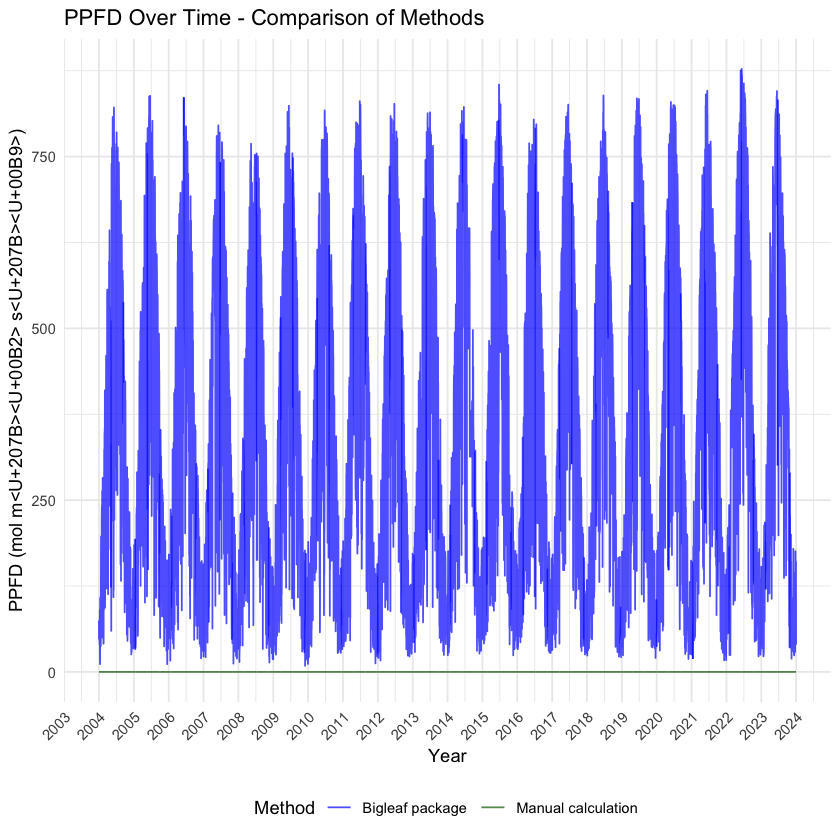

In [26]:
# Load ggplot2 for plotting
library(ggplot2)

# Add year column for plotting
ppfd_data$year <- year(ppfd_data$date)

# Create a plot for the PPFD data with both calculations
plot <- ggplot(ppfd_data, aes(x = date)) +
    geom_line(aes(y = ppfd, color = "Manual calculation"), alpha = 0.7, size = 0.5) +
    geom_line(aes(y = ppfd_bigleaf, color = "Bigleaf package"), alpha = 0.7, size = 0.5) +
    scale_color_manual(values = c("Manual calculation" = "darkgreen", "Bigleaf package" = "blue")) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 years") +
    labs(title = "PPFD Over Time - Comparison of Methods",
         x = "Year",
         y = "PPFD (mol m⁻² s⁻¹)",
         color = "Method") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")

# Display the plot
print(plot)

# Create the directory for trend plots if it does not exist
if (!dir.exists("../data/01_data_prep/trend_plots")) {
    dir.create("../data/01_data_prep/trend_plots", recursive = TRUE)
}

# Save the plot as a PNG file
ggsave("../data/01_data_prep/trend_plots/03_ppfd_plot.png", plot = plot, width = 15, height = 8, bg = "white", dpi = 300)